In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
customers = pd.read_csv('./dacon_data/open/customers.csv')
locations = pd.read_csv('./dacon_data/open/locations.csv')
orders = pd.read_csv('./dacon_data/open/orders.csv')
order_items = pd.read_csv('./dacon_data/open/order_items.csv')
payments = pd.read_csv('./dacon_data/open/payments.csv')
products = pd.read_csv('./dacon_data/open/products.csv')
reviews = pd.read_csv('./dacon_data/open/reviews.csv')
sellers = pd.read_csv('./dacon_data/open/sellers.csv')
temp = pd.merge(reviews,order_items, how='inner',on='Order_id')
temp = pd.merge(temp,orders, how='inner',on='Order_id')
temp = pd.merge(temp,payments, how='inner',on='Order_id')
temp = pd.merge(temp,products, how='inner',on='Product_id')
temp = pd.merge(temp,customers, how='inner',on='Customer_id')
temp = pd.merge(temp,sellers, how='inner',on='Seller_id')
# temp = temp.drop(["Review_creation_date","Review_answer_timestamp","Order_status","Payment_sequential","Payment_type","Payment_installments"],axis=1)
locations_group_lat=locations.groupby(["Geolocation_zipcode_prefix"])["Geolocation_lat"].mean().reset_index()
locations_group_lng=locations.groupby(["Geolocation_zipcode_prefix"])["Geolocation_lng"].mean().reset_index()
locations_group =  pd.merge(locations_group_lat, locations_group_lng, how = 'inner', on="Geolocation_zipcode_prefix")
temp = pd.merge(temp, locations_group, left_on = 'Customer_zipcode_prefix', right_on = 'Geolocation_zipcode_prefix', how = 'inner')
temp = temp.rename(columns={'Geolocation_lat':'Customer_lat',"Geolocation_lng" : "Customer_lng" })
temp = pd.merge(temp, locations_group, left_on = 'Seller_zipcode_prefix', right_on = 'Geolocation_zipcode_prefix', how = 'inner')
temp = temp.rename(columns={'Geolocation_lat':'Seller_lat',"Geolocation_lng" : "Seller_lng" })
temp.drop(["Geolocation_zipcode_prefix_x","Geolocation_zipcode_prefix_y","Customer_zipcode_prefix", "Seller_zipcode_prefix"], axis=1,inplace=True)
temp["Distance"] = ((temp["Customer_lat"] - temp["Seller_lat"])**2 + (temp["Customer_lng"] - temp["Seller_lng"])**2) **(1/2)


In [80]:
temp['Order_purchase_timestamp']=pd.to_datetime(temp['Order_purchase_timestamp'])

In [81]:
temp['YearMonth'] = temp['Order_purchase_timestamp'].dt.strftime('%Y%m') #월별로 분류

In [59]:
# Order_delivered_carrier_date : 물류 처리 시간 과  # Order_purchase_timestamp : 구매 시간 # Order_delivered_customer_date : 실제 배송 날짜 
# # Freight_value : 품목 화물 가격 비교

In [82]:
temp[['Order_delivered_carrier_date','Order_delivered_customer_date',"Order_purchase_timestamp"]] = temp[['Order_delivered_carrier_date','Order_delivered_customer_date',"Order_purchase_timestamp"]].apply(pd.to_datetime)

In [83]:
temp["to_carrier_time"]= temp['Order_delivered_carrier_date'] - temp['Order_purchase_timestamp']

In [84]:
#실제 배송도착은 없다...
temp["to_delivery_time"] =temp['Order_delivered_customer_date'] - temp['Order_delivered_carrier_date']

In [85]:
temp["to_time"] = temp["Order_delivered_customer_date"] - temp["Order_purchase_timestamp"]

In [86]:
temp["total_second_carrier"] = temp["to_carrier_time"].apply(lambda x : x.total_seconds())
temp["total_second_deivery"] = temp["to_delivery_time"].apply(lambda x : x.total_seconds())
temp["total_second_time"] = temp["to_time"].apply(lambda x : x.total_seconds())

In [87]:
temp_distance_time = temp[["Freight_value","Distance","to_carrier_time","to_delivery_time","total_second_carrier","total_second_deivery","total_second_time"]]

In [88]:
temp_distance_time.corr(numeric_only=True, method='pearson')
#total_second_deivery가 의미가 있는 양의 상관계숙 띈다. 이것
# 거리랑 총 구매시간부터~배송출발시간 그리고 물류처리시간~배송출발시간

,Freight_value,Distance,total_second_carrier,total_second_deivery,total_second_time
Freight_value,1.000000,0.389278,0.093304,0.202336,0.220326
Distance,0.389278,1.000000,0.019257,0.429385,0.399764
total_second_carrier,0.093304,0.019257,1.000000,0.029893,0.406626
total_second_deivery,0.202336,0.429385,0.029893,1.000000,0.925342
total_second_time,0.220326,0.399764,0.406626,0.925342,1.000000


In [89]:
temp.Payment_type.unique()

array(['credit_card', 'boleto', 'voucher', 'debit_card'], dtype=object)

In [90]:
temp[temp.Payment_type=="credit_card"]["Payment_installments"].unique()

array([ 8,  1, 10,  2,  3,  4,  6,  5,  7,  9, 15, 18, 12, 17, 20, 13, 14,
       24, 11,  0, 21, 16, 22, 23])

In [91]:
temp.iloc[0]

Review_id                                 REVIEW_00000
Order_id                                   ORDER_01674
Review_score                                         4
Review_creation_date               2019-01-18 00:00:00
Review_answer_timestamp            2019-01-18 21:46:59
Order_item_id                                        1
Product_id                               PRODUCT_21853
Seller_id                                  SELLER_0286
Price                                            185.0
Freight_value                                    13.63
Customer_id                             CUSTOMER_38995
Order_status                                 delivered
Order_purchase_timestamp           2019-01-11 15:30:49
Order_delivered_carrier_date       2019-01-12 21:57:22
Order_delivered_customer_date      2019-01-17 18:42:41
Order_estimated_delivery_date               2019-02-02
Payment_sequential                                   1
Payment_type                               credit_card
Payment_in

In [116]:
#월별로분류하기
temp["Year"] = temp["YearMonth"].apply(lambda x : x[:4])
temp["Month"] = temp["YearMonth"].apply(lambda x : x[4:])
temp["earn"] = (temp['Price']-temp["Freight_value"]) * temp['Order_item_id'] #화물가치빼기
temp_month = temp.groupby(["YearMonth"])["earn"].sum().reset_index()

In [117]:
temp["YearMonth"].unique()

array(['201901', '201902', '201804', '201904', '201806', '201805',
       '201905', '201812', '201903', '201809', '201907', '201808',
       '201811', '201810', '201807', '201906', '201803', '201710',
       '201801', '201802', '201712'], dtype=object)

In [120]:
temp_month.head(1)

,YearMonth,earn
0,201710,38792.84


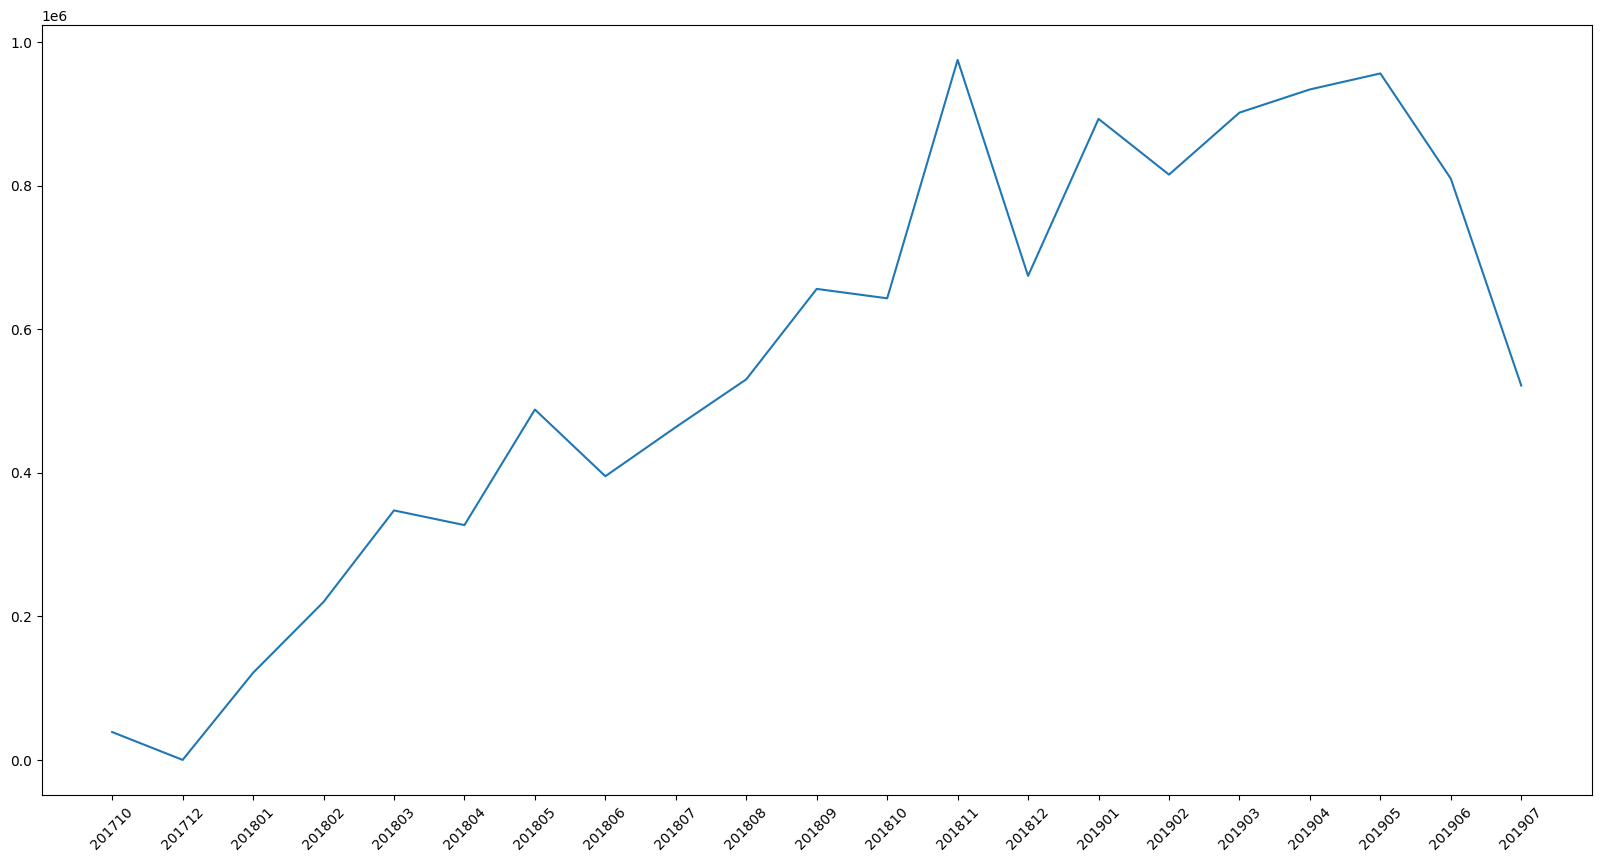

In [128]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,10)) ## 캔버스 생성
fig.set_facecolor('white') ## 캔버스 색상 설정
ax = fig.add_subplot() ## 그림 뼈대(프레임) 생성
ax.plot(temp_month['YearMonth'],temp_month['earn']) ## 선그래프 생성
plt.xticks(rotation=45) ## x축 눈금 라벨 설정 - 40도 회전 
plt.show()

# 2018 11 ~2018 12
# 2019 05 ~ 2019 06 07

In [125]:
temp_201811 = temp[temp["YearMonth"] == "201811"]
temp_201812 = temp[temp["YearMonth"] == "201812"]

In [126]:
temp_201811.describe()

,Review_score,Order_item_id,Price,Freight_value,Order_purchase_timestamp,Order_delivered_carrier_date,Order_delivered_customer_date,Payment_sequential,Payment_installments,Payment_value,...,Seller_lat,Seller_lng,Distance,to_carrier_time,to_delivery_time,to_time,total_second_carrier,total_second_deivery,total_second_time,earn
count,8780.000000,8780.000000,8780.000000,8780.000000,8780,8780,8780,8780.000000,8780.000000,8780.000000,...,8780.000000,8780.000000,8780.000000,8780,8780,8780,8.780000e+03,8.780000e+03,8.780000e+03,8780.000000
mean,3.890888,1.221526,115.893328,19.488495,2018-11-19 19:00:59.362072576,2018-11-23 21:50:33.943735808,2018-12-04 17:09:11.274715392,1.073804,3.153645,175.250432,...,-22.801254,-47.381337,5.609883,4 days 02:49:34.581662870,10 days 19:18:37.330979498,14 days 22:08:11.912642368,3.557746e+05,9.335173e+05,1.289292e+06,111.044715
min,1.000000,1.000000,3.900000,0.050000,2018-11-01 00:12:34,2018-11-01 18:13:00,2018-11-03 15:53:07,1.000000,1.000000,0.030000,...,-30.111751,-61.958415,0.000000,0 days 05:28:04,0 days 00:00:08,0 days 23:55:32,1.968400e+04,8.000000e+00,8.613200e+04,-173.610000
25%,3.000000,1.000000,39.900000,13.177500,2018-11-13 14:54:02.249999872,2018-11-16 21:56:25.500000,2018-11-24 19:22:30.249999872,1.000000,1.000000,61.725000,...,-23.613258,-48.829744,2.155024,1 days 17:55:24,5 days 01:59:25.500000,8 days 06:01:31.500000,1.509240e+05,4.391655e+05,7.128915e+05,27.600000
50%,5.000000,1.000000,69.990000,16.110000,2018-11-23 09:21:45,2018-11-25 02:33:05,2018-12-04 16:06:21.500000,1.000000,2.000000,110.300000,...,-23.302318,-46.762875,4.239518,3 days 04:38:36,8 days 05:38:20,12 days 10:12:08.500000,2.759160e+05,7.115000e+05,1.073528e+06,61.210000
75%,5.000000,1.000000,129.900000,19.700000,2018-11-25 18:54:39.750000128,2018-11-29 20:21:51.500000,2018-12-12 15:55:09,1.000000,4.000000,190.370000,...,-21.757321,-46.523183,7.440724,5 days 01:47:59.750000,13 days 21:48:54.500000,18 days 10:17:07.250000,4.384798e+05,1.201734e+06,1.592227e+06,123.032500
max,5.000000,15.000000,2990.000000,314.400000,2018-11-30 23:36:03,2019-03-20 15:44:40,2019-05-21 18:22:18,12.000000,24.000000,6081.540000,...,-3.953841,-34.894479,48.219429,125 days 18:36:45,167 days 22:33:32,173 days 03:12:04,1.086700e+07,1.451001e+07,1.495872e+07,5787.660000
std,1.462501,0.741134,166.517474,14.783746,NaN,NaN,NaN,0.508743,3.163641,269.629842,...,2.291362,2.372372,5.211967,4 days 12:52:34.004856668,9 days 07:12:14.654035321,10 days 10:43:11.945430244,3.919540e+05,8.035347e+05,9.025919e+05,199.473034


In [127]:
temp_201812.describe()

,Review_score,Order_item_id,Price,Freight_value,Order_purchase_timestamp,Order_delivered_carrier_date,Order_delivered_customer_date,Payment_sequential,Payment_installments,Payment_value,...,Seller_lat,Seller_lng,Distance,to_carrier_time,to_delivery_time,to_time,total_second_carrier,total_second_deivery,total_second_time,earn
count,6362.000000,6362.000000,6362.000000,6362.000000,6362,6362,6362,6362.000000,6362.000000,6362.000000,...,6362.000000,6362.000000,6362.000000,6362,6362,6362,6.362000e+03,6.362000e+03,6.362000e+03,6362.000000
mean,3.996542,1.163313,116.388848,18.866850,2018-12-13 22:45:32.130619392,2018-12-17 16:37:38.143822592,2018-12-29 04:00:44.087079424,1.096511,2.906004,157.830883,...,-22.888174,-47.212034,5.446978,3 days 17:52:06.013203395,11 days 11:23:05.943256837,15 days 05:15:11.956460232,3.235260e+05,9.913859e+05,1.314912e+06,105.967939
min,1.000000,1.000000,4.400000,0.030000,2018-12-01 00:01:14,2018-12-01 17:48:57,2018-12-03 16:12:30,1.000000,1.000000,0.170000,...,-30.111751,-61.958415,0.004245,0 days 06:53:31,0 days 06:19:29,1 days 02:36:17,2.481100e+04,2.276900e+04,9.577700e+04,-95.640000
25%,3.000000,1.000000,41.492500,12.910000,2018-12-06 11:28:48.249999872,2018-12-09 15:37:05,2018-12-19 17:12:13.500000,1.000000,1.000000,62.322500,...,-23.625475,-48.543584,1.669394,1 days 08:33:01,5 days 01:33:38.500000,8 days 01:50:56.750000,1.171810e+05,4.376185e+05,6.978568e+05,29.790000
50%,5.000000,1.000000,76.930000,15.590000,2018-12-12 17:15:23,2018-12-15 17:33:01,2018-12-27 21:08:38,1.000000,1.000000,106.825000,...,-23.431131,-46.743468,4.013596,2 days 20:41:06.500000,8 days 23:39:16.500000,13 days 01:28:37.500000,2.472665e+05,7.763565e+05,1.128518e+06,64.715000
75%,5.000000,1.000000,130.900000,18.790000,2018-12-20 10:06:58.750000128,2018-12-22 19:22:23,2019-01-05 23:40:30.500000,1.000000,4.000000,183.257500,...,-21.865404,-46.523183,7.252956,4 days 17:51:19,15 days 01:34:46,19 days 19:29:15,4.098790e+05,1.301686e+06,1.711755e+06,124.965000
max,5.000000,14.000000,3124.000000,177.940000,2018-12-31 23:29:31,2019-02-06 22:38:32,2019-04-28 15:51:50,22.000000,24.000000,2734.660000,...,-3.717490,-35.126887,30.553678,49 days 14:35:37,136 days 01:05:49,138 days 06:29:22,4.286137e+06,1.175435e+07,1.194656e+07,2950.600000
std,1.400133,0.612878,161.629153,13.679872,NaN,NaN,NaN,0.832331,2.776419,189.931228,...,2.307019,2.258962,5.351397,3 days 22:28:15.670724185,9 days 08:51:13.286522205,10 days 07:13:14.948980221,3.400957e+05,8.094733e+05,8.899949e+05,165.197416
